# Machine Learning with PySpark MLlib

## Overview of PySpark MLlib
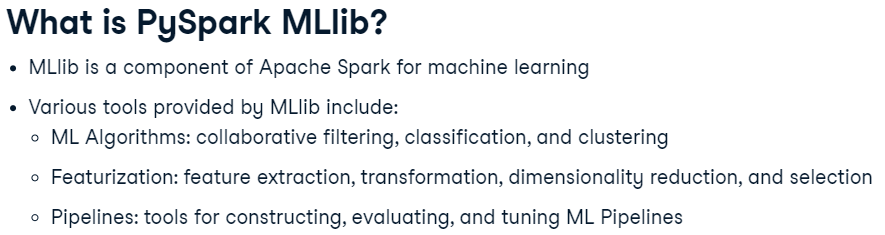

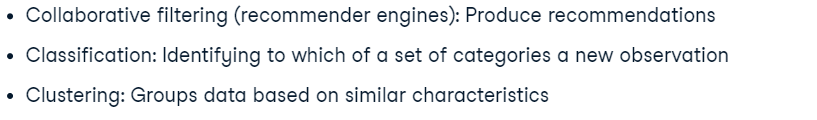

In [1]:
import pyspark as sp
sc = sp.SparkContext.getOrCreate()

## PySpark MLlib algorithms

In [2]:
# Import the library for ALS
from pyspark.mllib.recommendation import ALS

# Import the library for Logistic Regression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

# Import the library for Kmeans
from pyspark.mllib.clustering import KMeans

## Collaborative filtering
Collaborative filtering is a technique for recommender systems wherein users' ratings and interactions with various products are used to recommend new ones. 
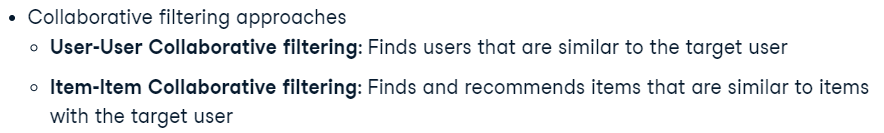

**`Rating()` class in pyspark.mllib.recommendation submodule**
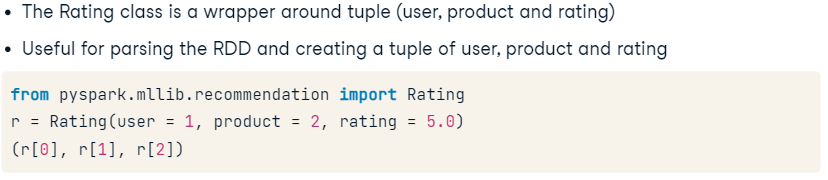

**Splitting the data using `randomSplit()`**
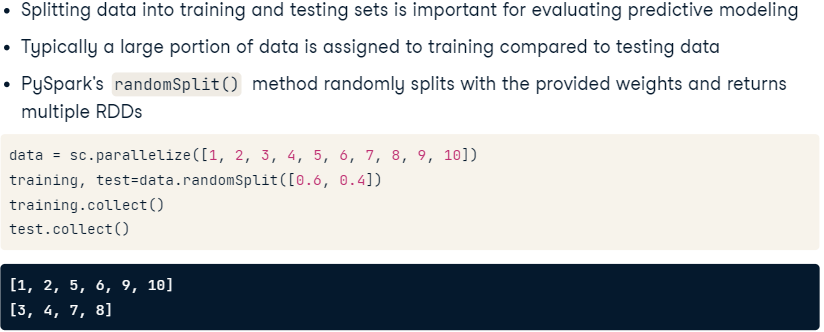

**Alternating Least Squares (ALS)**
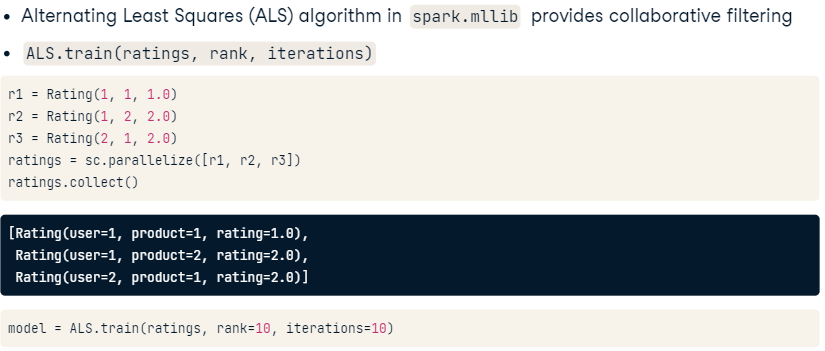

**`predictAll()` - Returns RDD of Rating Objects**
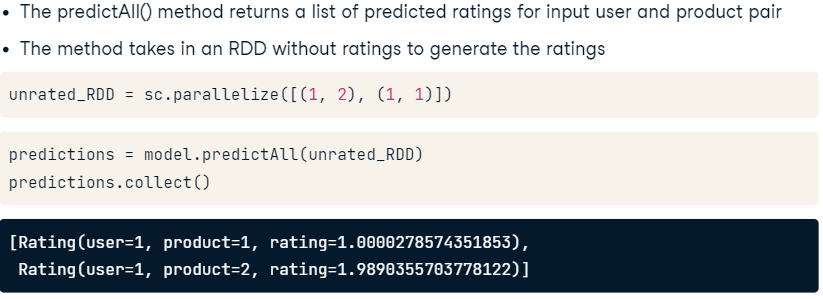

**Model evaluation using MSE**
* Mean Squared Error (MSE). The MSE measures the average of the squares of the errors between what is estimated and the existing data. 
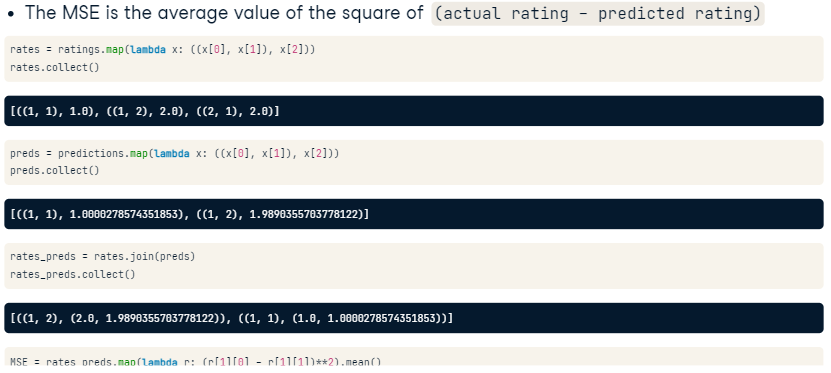

## Loading Movie Lens dataset into RDDs
### The goal is to develop a simple movie recommendation system using PySpark MLlib
* In the first part, you'll first load the MovieLens data (ratings.csv) into RDD and from each line in the RDD which is formatted as userId,movieId,rating,timestamp, you'll need to map the MovieLens data to a Ratings object (userID, productID, rating) after removing timestamp column and finally you'll split the RDD into training and test RDDs.

In [12]:
from pyspark.mllib.recommendation import Rating

In [2]:
file_path = 'ratings.csv'

In [13]:
# Load the data into RDD
data = sc.textFile(file_path)

# Split the RDD 
ratings = data.map(lambda l: l.split(','))

# Transform the ratings RDD 
ratings_final = ratings.map(lambda line: Rating(int(line[0]), int(line[1]), float(line[2])))

# Split the data into training and test
training_data, test_data = ratings_final.randomSplit([0.8, 0.2])

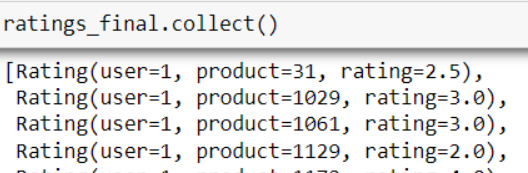

## Model training and predictions
* After splitting the data into training and test data, in the second part, you'll train the ALS algorithm using the training data. 
* PySpark MLlib's ALS algorithm has the following mandatory parameters - `rank` (the number of latent factors in the model) and `iterations` (number of iterations to run). 
* After training the ALS model, you can use the model to predict the ratings from the test data. For this, you will provide the user and item columns from the test dataset and finally return the list of 2 rows of predictAll() output.

In [17]:
# Create the ALS model on the training data
model = ALS.train(training_data, rank=10, iterations=10)

# Drop the ratings column 
testdata_no_rating = test_data.map(lambda p: (p[0], p[1]))

# Predict the model  
predictions = model.predictAll(testdata_no_rating)

# Return the first 2 rows of the RDD
predictions.take(2)

[Rating(user=80, product=1084, rating=4.507511269336447),
 Rating(user=608, product=1084, rating=4.120629334554774)]

## Model evaluation using MSE
* After generating the predicted ratings from the test data using ALS model, in this final, you'll prepare the data for calculating Mean Square Error (MSE) of the model. The MSE is the average value of `(original rating – predicted rating)**2` for all users and indicates the absolute fit of the model to the data. 
* To do this, first, you'll organize both the ratings and prediction RDDs to make a tuple of ((user, product), rating)), then join the ratings RDD with prediction RDD and finally apply a squared difference function along with `mean()` to get the MSE.

In [19]:
# Prepare ratings data
rates = ratings_final.map(lambda r: ((r[0], r[1]), r[2]))

# Prepare predictions data
preds = predictions.map(lambda r: ((r[0], r[1]), r[2]))

# Join the ratings data with predictions data
rates_and_preds = rates.join(preds)

# Calculate and print MSE
MSE = rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error of the model for the test data = {:.2f}".format(MSE))

Mean Squared Error of the model for the test data = 1.37


## Classification
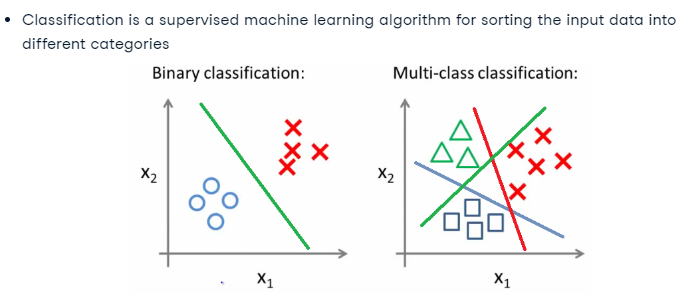

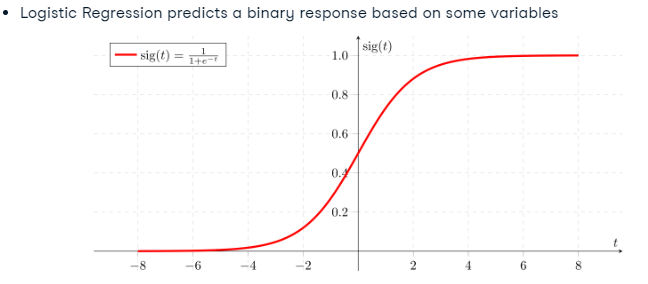

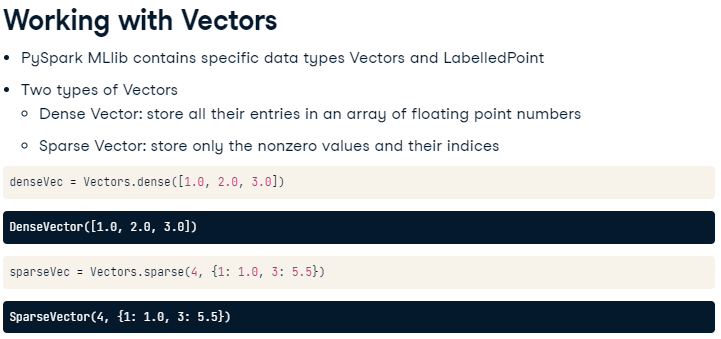

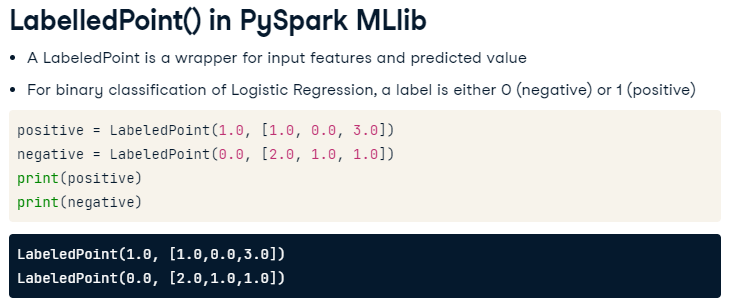

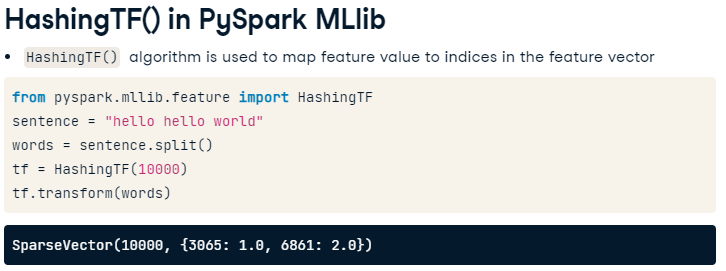

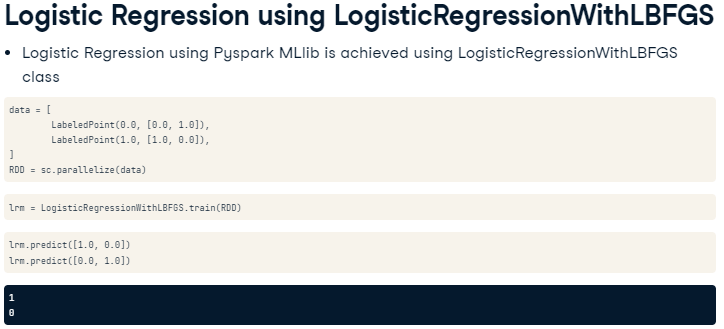

## Loading spam and non-spam data
#### create an email spam classifier with logistic regression using Spark MLlib. Here are the brief steps for creating a spam classifier.
* Create an RDD of strings representing email.
* Run MLlib’s feature extraction algorithms to convert text into an RDD of vectors.
* Call a classification algorithm on the RDD of vectors to return a model object to classify new points.
* Evaluate the model on a test dataset using one of MLlib’s evaluation functions.

* In the first part, you'll load the 'spam' and 'ham' (non-spam) files into RDDs, split the emails into individual words and look at the first element in each of the RDD.

In [24]:
file_path_spam = 'spam.txt'
file_path_non_spam = 'ham.txt'

In [56]:
# Load the datasets into RDDs
spam_rdd = sc.textFile(file_path_spam)
non_spam_rdd = sc.textFile(file_path_non_spam)

# Split the email messages into words
spam_words = spam_rdd.flatMap(lambda email: email.split(' '))
non_spam_words = non_spam_rdd.flatMap(lambda email: email.split(' '))

# Print the first element in the split RDD
print("The first element in spam_words is", spam_words.first())
print("The first element in non_spam_words is", non_spam_words.first())

The first element in spam_words is You
The first element in non_spam_words is Rofl.


## Feature hashing and LabelPoint
* After splitting the emails into words, our raw data set of 'spam' and 'non-spam' is currently composed of 1-line messages consisting of spam and non-spam messages. In order to classify these messages, we need to convert text into features.
* In the second part, you'll first create a `HashingTF()` instance to map text to vectors of 200 features, then for each message in 'spam' and 'non-spam' files you'll split them into words, and each word is mapped to one feature. These are the features that will be used to decide whether a message is 'spam' or 'non-spam'. 
* Next, you'll create labels for features. For a valid message, the label will be 0 (i.e. the message is not spam) and for a 'spam' message, the label will be 1 (i.e. the message is spam). 
* Finally, you'll combine both the labeled datasets.

In [53]:
from pyspark.ml.feature import HashingTF
from pyspark.mllib.regression import LabeledPoint

In [ ]:
# Create a HashingTf instance with 200 features
tf = HashingTF(numFeatures=200)

# Map each word to one feature
spam_features = tf.transform(spam_words)
non_spam_features = tf.transform(non_spam_words)

# Label the features: 1 for spam, 0 for non-spam
spam_samples = spam_features.map(lambda features:LabeledPoint(1, features))
non_spam_samples = non_spam_features.map(lambda features:LabeledPoint(0, features))

# Combine the two datasets
samples = spam_samples.union(non_spam_samples)

## Logistic Regression model training
* After creating labels and features for the data, we’re ready to build a model that can learn from it (training). 
* But before you train the model, in this final part, you'll split the data into training and test, run Logistic Regression model on the training data
* finally check the accuracy of the model trained on training data.

In [ ]:
# Split the data into training and testing
train_samples,test_samples = samples.randomSplit([0.8, 0.2])

# Train the model
model = LogisticRegressionWithLBFGS.train(train_samples)

# Create a prediction label from the test data
predictions = model.predict(test_samples.map(lambda x: x.features))

# Combine original labels with the predicted labels
labels_and_preds = test_samples.map(lambda x: x.label).zip(predictions)

# Check the accuracy of the model on the test data
accuracy = labels_and_preds.filter(lambda x: x[0] == x[1]).count() / float(test_samples.count())
print("Model accuracy : {:.2f}".format(accuracy))

Model accuracy : 0.74

## Clustering
Clustering is the unsupervised learning task that involves grouping objects into clusters of high similarity. Unlike the supervised tasks, where data is labeled, clustering can be used to make sense of unlabeled data.
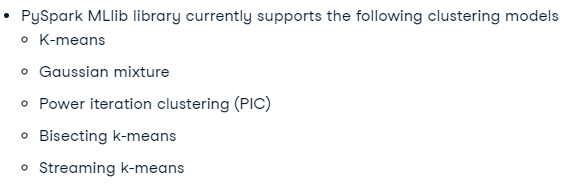

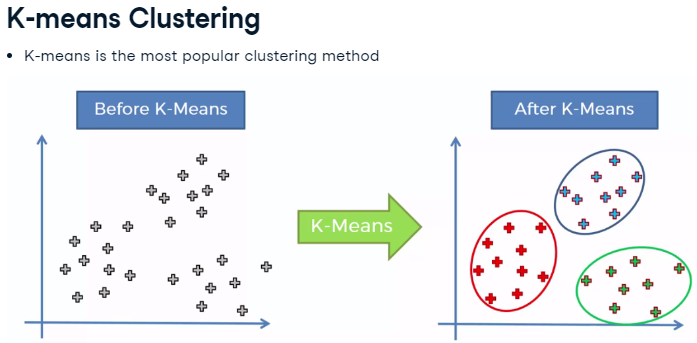

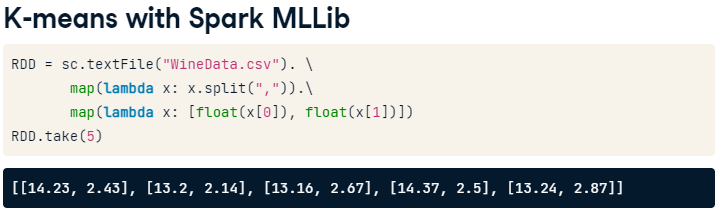

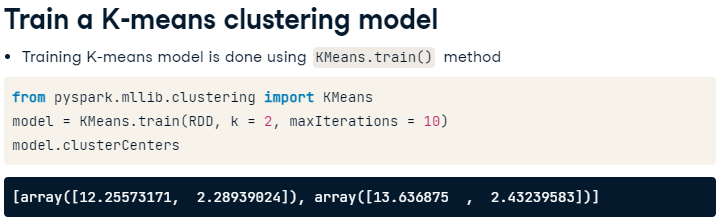

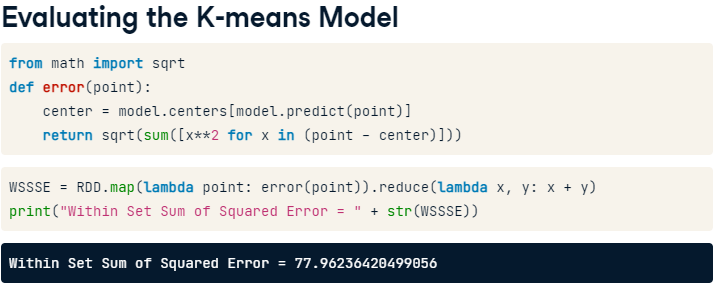

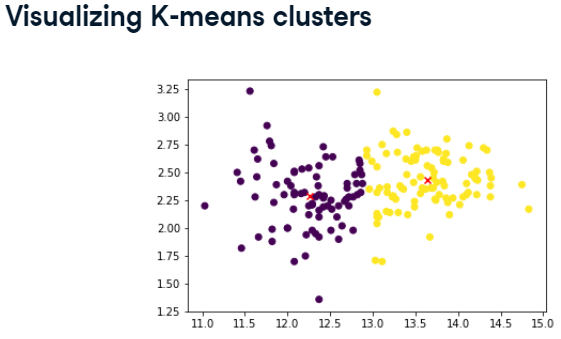

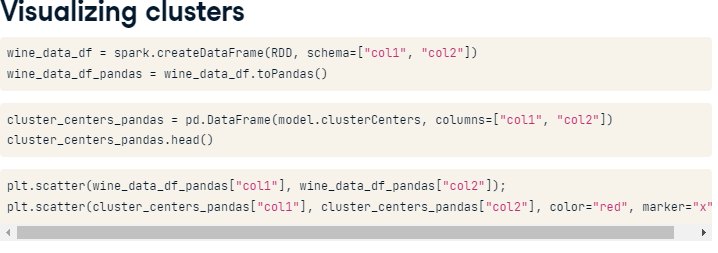

## Loading and parsing the 5000 points data
* Find out how many clusters are there in a dataset containing 5000 rows and 2 columns. For this you'll first load the data into an RDD, parse the RDD based on the delimiter, run the KMeans model, evaluate the model and finally visualize the clusters.

* In the first part, you'll load the data into RDD, parse the RDD based on the delimiter and convert the string type of the data to an integer.

In [4]:
file_path = '5000_points.txt'

In [5]:
# Load the dataset into an RDD
clusterRDD = sc.textFile(file_path)

# Split the RDD based on tab
rdd_split = clusterRDD.map(lambda x: x.split("\t"))

# Transform the split RDD by creating a list of integers
rdd_split_int = rdd_split.map(lambda x: [int(x[0]), int(x[1])])

# Count the number of rows in RDD 
print("There are {} rows in the rdd_split_int dataset".format(rdd_split_int.count()))

There are 5000 rows in the rdd_split_int dataset


## K-means training
Now that the RDD is ready for training, in this 2nd part, you'll test with k's from 13 to 16 (to save computation time) and use the **elbow** method to chose the correct k. The idea of the elbow method is to run K-means clustering on the dataset for different values of k, calculate Within Set Sum of Squared Error (WSSSE) and select the best k based on the sudden drop in WSSSE. Next, you'll retrain the model with the best k and finally, get the centroids (cluster centers).
* The elbow point is the point in the plot where the rate of decrease in WSSSE slows down significantly. This point represents the optimal number of clusters. Choose the value of K at the elbow point as the best WSSSE for K-means.

In [7]:
from math import sqrt
def error(point):
    center = model.centers[model.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

In [8]:
# Train the model with clusters from 13 to 16 and compute WSSSE
for clst in range(13, 17):
    model = KMeans.train(rdd_split_int, clst, seed=1)
    WSSSE = rdd_split_int.map(lambda point: error(point)).reduce(lambda x, y: x + y)
    print("The cluster {} has Within Set Sum of Squared Error {}".format(clst, WSSSE))

The cluster 13 has Within Set Sum of Squared Error 249164132.49410182
The cluster 14 has Within Set Sum of Squared Error 209371154.24941802
The cluster 15 has Within Set Sum of Squared Error 169394691.52639425
The cluster 16 has Within Set Sum of Squared Error 202384225.6640126


The best WSSSE for K-means depends on the specific context of your clustering problem, but generally, the cluster with the lowest WSSSE value is considered the best cluster.

In this case, the cluster with the lowest WSSSE value is the cluster 15, which has a WSSSE of 169394691.52639425. Therefore, if you have to choose the best cluster among these four options, cluster 15 would be the best option.

In [11]:
# Train the model again with the best k
model = KMeans.train(rdd_split_int, k=15, seed=1)

# Get cluster centers
cluster_centers = model.clusterCenters

## Visualizing clusters
You just trained the k-means model with an optimum k value (k=15) and generated cluster centers (centroids). 
* In the final part, you will visualize the clusters and the centroids by overlaying them. This will indicate how well the clustering worked (ideally, the clusters should be distinct from each other and centroids should be at the center of their respective clusters).

* To achieve this, you will first convert the rdd_split_int RDD into a Spark DataFrame, and then into Pandas DataFrame which can be used for plotting. Similarly, you will convert cluster_centers into a Pandas DataFrame. Once both the DataFrames are created, you will create scatter plots using Matplotlib.

In [18]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession 
# Create spark
spark = SparkSession.builder.getOrCreate()

import pandas as pd
from matplotlib import pyplot as plt


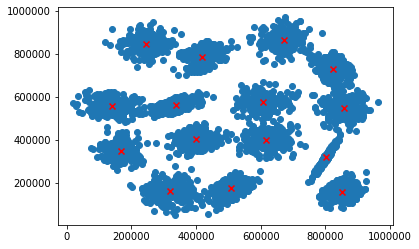

In [25]:
# Convert rdd_split_int RDD into Spark DataFrame and then to Pandas DataFrame
rdd_split_int_df_pandas = spark.createDataFrame(rdd_split_int, schema=["col1", "col2"]).toPandas()

# Convert cluster_centers to a pandas DataFrame
cluster_centers_pandas = pd.DataFrame(cluster_centers, columns=["col1", "col2"])

# Create an overlaid scatter plot of clusters and centroids
plt.scatter(rdd_split_int_df_pandas["col1"], rdd_split_int_df_pandas["col2"])
plt.scatter(cluster_centers_pandas["col1"], cluster_centers_pandas["col2"], color="red", marker="x")
plt.show()